In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import math
import numpy as np

from sklearn.preprocessing import StandardScaler
#from yellowbrick.regressor import ResidualsPlot

##  Carrega dados

In [2]:
df = pd.read_csv("data/08.2019/casas_completo.csv")

df = df.drop(['Unnamed: 0'],axis=1)
df.reset_index(inplace=True,drop=True)
print(df.shape)
df.head()

(18600, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,SHIS QI 28 PROJETO AGRADÁVEL - Whatsapp - José...,2300000,https://www.wimoveis.com.br/propriedades/shis-...,NaN,NaN,-15.813517400000000,-47.811048499999970,776m²,400m²,6.0,NaN,4.0,3.0,NaN,"SHIS QI 28, Lago Sul, Brasília",", Lago Sul, Brasília",143
1,LAGO SUL - 4Qts* 2 Sts - PROJETO ARQUITETÔNICO...,2490000,https://www.wimoveis.com.br/propriedades/lago-...,NaN,NaN,-15.863871300000000,-47.875655400000030,1500m²,800m²,5.0,4.0,4.0,2.0,8,"SHIS QI 17, Lago Sul, Brasília",", Lago Sul, Brasília",12
2,VENDO LINDA CASA ACEITO APTO NOROESTE,2250000,https://www.wimoveis.com.br/propriedades/vendo...,NaN,NaN,-15.749581800000000,-47.909860200000026,426m²,426m²,7.0,0.0,4.0,4.0,15,"SQNW 108, Noroeste, Brasília",", Noroeste, Brasília",82
3,CASA - VICENTE PIRES,850000,https://www.wimoveis.com.br/propriedades/casa-...,NaN,NaN,-15.660260199999999,-48.196478499999997,NaN,NaN,NaN,NaN,4.0,2.0,NaN,", Vicente Pires, Vicente Pires",", Vicente Pires, Vicente Pires",\n Publicado hoje\n
4,"QE 15 Laje, sótão, oportunidade!!!",540000,https://www.wimoveis.com.br/propriedades/qe-15...,NaN,NaN,-15.829574477730766,-47.977716817860426,140m²,120m²,2.0,2.0,3.0,1.0,17,"Qe 15, Guara II, Guará",", Guara II, Guará",10


In [3]:
df.dtypes

nome              object
valor_venda        int64
url               object
condominio        object
IPTU              object
lat               object
long              object
area_total        object
area_util         object
banheiros        float64
vagas            float64
quartos          float64
suites           float64
idade             object
endereco          object
bairro            object
idade_anuncio     object
dtype: object

### Dropa imoveis que não tem latitude, longitude e área útil

In [4]:
df.dropna(subset=['lat', 'long','area_util','bairro'],inplace=True)
df.shape

(13770, 17)

### Quantidade de valores nulos por coluna

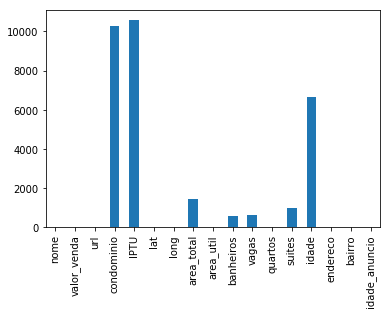

In [5]:
df.isna().sum().plot.bar()

In [6]:
df.isna().sum()

nome                 0
valor_venda          0
url                  0
condominio       10266
IPTU             10571
lat                  0
long                 0
area_total        1423
area_util            0
banheiros          596
vagas              631
quartos             12
suites             962
idade             6664
endereco             0
bairro               0
idade_anuncio        0
dtype: int64

### Remove outliers do preço de venda

In [7]:
print(df.shape)
df.valor_venda.describe()

(13770, 17)


count    1.377000e+04
mean     4.026682e+06
std      7.902858e+07
min      2.800000e+02
25%      4.300000e+05
50%      7.500000e+05
75%      1.500000e+06
max      7.790000e+09
Name: valor_venda, dtype: float64

### 6 bilhões parece muito para um imóvel
Vamos remover aqueles que custam a partir de 12 milhões

In [8]:
df = df.loc[df.valor_venda < 5000000]
print(df.shape)
df.valor_venda.describe()

(13303, 17)


count    1.330300e+04
mean     1.041812e+06
std      9.110944e+05
min      2.800000e+02
25%      4.200000e+05
50%      7.450000e+05
75%      1.390000e+06
max      4.999999e+06
Name: valor_venda, dtype: float64

### Remove outliers da area util

In [9]:
df.area_util = df.area_util.str.replace('m²','')
df.area_util = pd.to_numeric(df.area_util)

In [10]:
print(df.shape)
df.area_util.describe()

(13303, 17)


count    1.330300e+04
mean     6.192476e+03
std      6.225579e+05
min      1.000000e+00
25%      1.770000e+02
50%      2.980000e+02
75%      4.480000e+02
max      7.163026e+07
Name: area_util, dtype: float64

## 143mil m2  parece muito para um apartamento
Vamos remover aqueles que sao maiores que 1000 m2

In [11]:
df = df.loc[(df.area_util < 1000) & (df.area_util > 18)]
print(df.shape)
df.area_util.describe()

(12912, 17)


count    12912.000000
mean       318.900713
std        189.583477
min         24.000000
25%        171.750000
50%        281.000000
75%        420.000000
max        996.000000
Name: area_util, dtype: float64

In [12]:
df.idade_anuncio = df.idade_anuncio.str.replace("\n Publicado desde ontem\n","1")
df.idade_anuncio = df.idade_anuncio.str.replace("\n Publicado hoje\n","0")
df.idade_anuncio.value_counts()

1      756
2      439
0      434
10     287
83     276
4      255
5      229
3      211
268    195
16     194
82     191
17     176
19     151
9      141
22     138
24     138
61     133
11     126
47     122
12     116
23     115
18     113
52     111
46     108
8      105
32     102
25     101
15      94
115     92
59      90
      ... 
406      1
427      1
883      1
385      1
735      1
857      1
826      1
678      1
407      1
898      1
753      1
831      1
604      1
740      1
659      1
772      1
575      1
656      1
884      1
752      1
677      1
394      1
679      1
658      1
464      1
713      1
642      1
703      1
345      1
542      1
Name: idade_anuncio, Length: 705, dtype: int64

### Checa distribuição dos Bairros

In [13]:
df.bairro = df.bairro.str.replace(",  ","")
df.bairro.value_counts()

Vicente Pires, Vicente Pires                           1215
Lago Sul, Brasília                                     1191
Setor Habitacional Jardim Botânico, Brasília           1055
Park Way, Brasília                                      839
Taguatinga Norte, Taguatinga                            575
Lago Norte, Brasília                                    545
Guara II, Guará                                         509
Grande Colorado, Sobradinho                             310
Guara I, Guará                                          281
Samambaia Norte, Samambaia                              261
Sobradinho, Sobradinho                                  257
Ceilandia Sul, Ceilândia                                255
Ceilandia Norte, Ceilândia                              250
Taguatinga Sul, Taguatinga                              246
Região Dos Lagos, Sobradinho                            240
Setor Habitacional Contagem, Sobradinho                 197
Asa Sul, Brasília                       

In [14]:
bairros_goiania = ['Setor Bueno, Goiânia','Setor Marista, Goiânia','Jardim Goiás, Goiânia','Setor Oeste, Goiânia',
                  'Parque Amazônia, Goiânia','Jardim América, Goiânia']
df = df[~df['bairro'].isin(bairros_goiania)]
df.bairro.value_counts()

Vicente Pires, Vicente Pires                           1215
Lago Sul, Brasília                                     1191
Setor Habitacional Jardim Botânico, Brasília           1055
Park Way, Brasília                                      839
Taguatinga Norte, Taguatinga                            575
Lago Norte, Brasília                                    545
Guara II, Guará                                         509
Grande Colorado, Sobradinho                             310
Guara I, Guará                                          281
Samambaia Norte, Samambaia                              261
Sobradinho, Sobradinho                                  257
Ceilandia Sul, Ceilândia                                255
Ceilandia Norte, Ceilândia                              250
Taguatinga Sul, Taguatinga                              246
Região Dos Lagos, Sobradinho                            240
Setor Habitacional Contagem, Sobradinho                 197
Asa Sul, Brasília                       

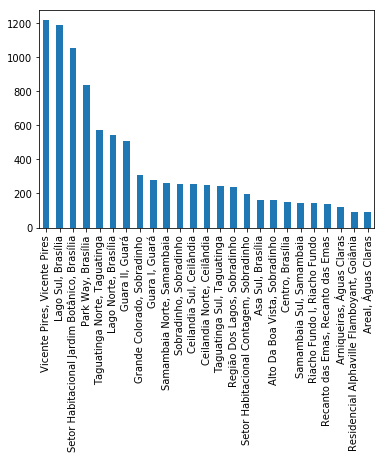

In [15]:
df.bairro.value_counts()[:25].plot.bar()

### Remove bairros com menos imóveis (pega so 25 +)

In [16]:
df.bairro.value_counts()[25:]

Ponte Alta, Gama                                       87
Riacho Fundo II, Riacho Fundo                          71
Taquari, Brasília                                      68
Alphaville Flamboyant Residencial Araguaia, Goiânia    68
Colônia Agrícola Samambaia, Vicente Pires              67
Jardins Valência, Goiânia                              66
Santa Maria, Santa Maria                               65
Setor Habitacional Vicente Pires, Taguatinga           59
Setor Leste, Gama                                      54
Candangolandia, Candangolândia                         52
Setor Oeste, Gama                                      50
Riacho Fundo, Riacho Fundo                             49
Setor De Mansões De Sobradinho, Sobradinho             49
Residencial Santos Dumont, Santa Maria                 48
Asa Norte, Brasília                                    44
Cruzeiro Velho, Cruzeiro                               43
Samambaia, Samambaia                                   42
Nucleo Bandeir

In [17]:
bairros_reject = df.bairro.value_counts()[25:].index.values
bairros_reject

array(['Ponte Alta, Gama', 'Riacho Fundo II, Riacho Fundo',
       'Taquari, Brasília',
       'Alphaville Flamboyant Residencial Araguaia, Goiânia',
       'Colônia Agrícola Samambaia, Vicente Pires',
       'Jardins Valência, Goiânia', 'Santa Maria, Santa Maria',
       'Setor Habitacional Vicente Pires, Taguatinga',
       'Setor Leste, Gama', 'Candangolandia, Candangolândia',
       'Setor Oeste, Gama', 'Riacho Fundo, Riacho Fundo',
       'Setor De Mansões De Sobradinho, Sobradinho',
       'Residencial Santos Dumont, Santa Maria', 'Asa Norte, Brasília',
       'Cruzeiro Velho, Cruzeiro', 'Samambaia, Samambaia',
       'Nucleo Bandeirante, Núcleo Bandeirante',
       'Setor Habitacional Tororó, Santa Maria',
       'Jardins Verona, Goiânia', 'Mansões Aguas Quentes, Caldas Novas',
       'Paranoa, Paranoá', 'Setor Sul, Gama', 'Centro, Vicente Pires',
       'Setor Habitacional Tororo, Brasília',
       'Loteamento Portal do Sol II, Goiânia', 'Jardins Milão, Goiânia',
       'Jardin

In [18]:
df = df[~df['bairro'].isin(bairros_reject)]
print(df.shape)
df.head()

(9425, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,SHIS QI 28 PROJETO AGRADÁVEL - Whatsapp - José...,2300000,https://www.wimoveis.com.br/propriedades/shis-...,NaN,NaN,-15.813517400000000,-47.811048499999970,776m²,400,6.0,NaN,4.0,3.0,NaN,"SHIS QI 28, Lago Sul, Brasília","Lago Sul, Brasília",143
1,LAGO SUL - 4Qts* 2 Sts - PROJETO ARQUITETÔNICO...,2490000,https://www.wimoveis.com.br/propriedades/lago-...,NaN,NaN,-15.863871300000000,-47.875655400000030,1500m²,800,5.0,4.0,4.0,2.0,8,"SHIS QI 17, Lago Sul, Brasília","Lago Sul, Brasília",12
4,"QE 15 Laje, sótão, oportunidade!!!",540000,https://www.wimoveis.com.br/propriedades/qe-15...,NaN,NaN,-15.829574477730766,-47.977716817860426,140m²,120,2.0,2.0,3.0,1.0,17,"Qe 15, Guara II, Guará","Guara II, Guará",10
5,Lindo sobrado com 6 suítes em ParkWay quadra 27,2650000,https://www.wimoveis.com.br/propriedades/lindo...,R$ 350,NaN,-15.905274200000000,-47.918750400000020,NaN,750,8.0,2.0,6.0,6.0,9,"SMPW Quadra 27 conjunto C, Park Way, Brasília","Park Way, Brasília",4
6,Casa à venda - em Vicente Pires,900000,https://www.wimoveis.com.br/propriedades/casa-...,NaN,NaN,-15.794686999999999,-48.051364200000001,400m²,195,6.0,4.0,3.0,3.0,NaN,"RUA 12 CHACARA 129A CONJUNTO D, Vicente Pires...","Vicente Pires, Vicente Pires",23


In [19]:
df.bairro.value_counts()

Vicente Pires, Vicente Pires                    1215
Lago Sul, Brasília                              1191
Setor Habitacional Jardim Botânico, Brasília    1055
Park Way, Brasília                               839
Taguatinga Norte, Taguatinga                     575
Lago Norte, Brasília                             545
Guara II, Guará                                  509
Grande Colorado, Sobradinho                      310
Guara I, Guará                                   281
Samambaia Norte, Samambaia                       261
Sobradinho, Sobradinho                           257
Ceilandia Sul, Ceilândia                         255
Ceilandia Norte, Ceilândia                       250
Taguatinga Sul, Taguatinga                       246
Região Dos Lagos, Sobradinho                     240
Setor Habitacional Contagem, Sobradinho          197
Asa Sul, Brasília                                162
Alto Da Boa Vista, Sobradinho                    160
Centro, Brasília                              

In [20]:
df.quartos = df.quartos.fillna(df.quartos.median())

In [21]:
#df_regression = df[['bairro', 'area_util', 'quartos','valor_venda','lat','long',]]
#df_regression = df[['area_util', 'quartos','valor_venda','lat','long','idade_anuncio']]
df_regression = df[['area_util', 'quartos','valor_venda','lat','long']]
print(df_regression.shape)
df_regression.head()

(9425, 5)


,area_util,quartos,valor_venda,lat,long
0,400,4.0,2300000,-15.813517400000000,-47.811048499999970
1,800,4.0,2490000,-15.863871300000000,-47.875655400000030
4,120,3.0,540000,-15.829574477730766,-47.977716817860426
5,750,6.0,2650000,-15.905274200000000,-47.918750400000020
6,195,3.0,900000,-15.794686999999999,-48.051364200000001


In [22]:
df_regression.isna().sum()

area_util      0
quartos        0
valor_venda    0
lat            0
long           0
dtype: int64

In [23]:
#one_hot = pd.get_dummies(df_regression['bairro'], prefix="bairro")
#df_regression = df_regression.join(one_hot)

#df_regression = df_regression.drop(['bairro'], axis=1)

#df_regression.shape
#df_regression.head()

In [24]:
df_regression = df_regression.apply(pd.to_numeric)
#, errors='coerce'
df_regression.dtypes

area_util        int64
quartos        float64
valor_venda      int64
lat            float64
long           float64
dtype: object

## Reduz casas decimais do lat long para 3

In [25]:
df_regression.lat = df_regression.lat.round(3)
df_regression.long = df_regression.long.round(3)

In [26]:
#zscore
#mean = df_regression.mean(axis=0)
#std = df_regression.std(axis=0)

# zscore normalization
#df_regression = ( df_regression - mean ) / std

In [27]:
X = df_regression.drop(['valor_venda'],axis=1)
y = df_regression['valor_venda']
X.shape, y.shape

((9425, 4), (9425,))

In [28]:
#X_columns = X.columns.values
#X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X_columns)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8482, 4), (943, 4), (8482,), (943,))

In [30]:
reg = RandomForestRegressor(n_estimators=100) 
reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
reg.fit(X_train, y_train)
train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

In [32]:
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, test_predict))

rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print("Root Mean squared error: %.2f" % rmse)

print('R2 score: %.2f' % r2_score(y_test, test_predict))

Mean squared error: 120076056239.51
Root Mean squared error: 346519.92
R2 score: 0.82


Feature ranking:
1. feature area_util (0.594431)
2. feature long (0.191720)
3. feature lat (0.183765)
4. feature quartos (0.030084)


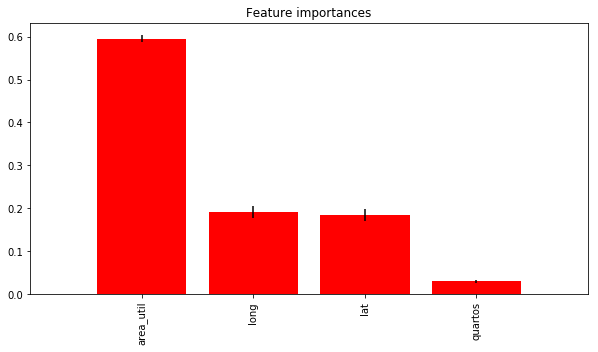

In [33]:
 plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):

    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [34]:
#reg2 = RandomForestRegressor(n_estimators=100) 

#visualizer = ResidualsPlot(reg2)
#visualizer.fit(X_train, y_train)  # Fit the training data to the model
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.poof()                 # Draw/show/poof the data

### TODO: scatterplot valor_venda x area util

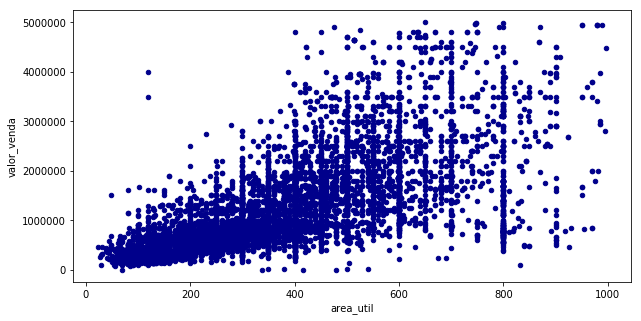

In [35]:

ax1 = df.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

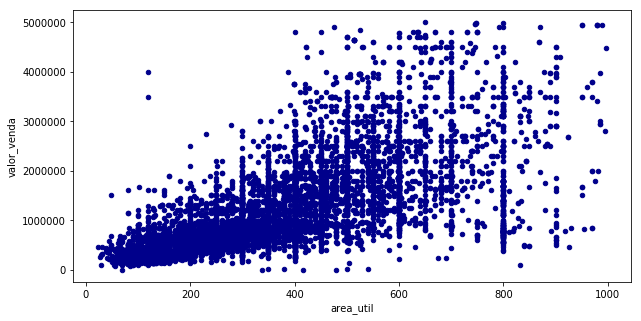

In [36]:
df_zoom = df.loc[df.area_util < 2001]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

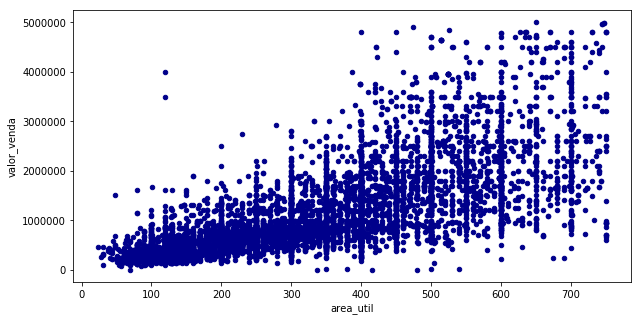

In [37]:
df_zoom = df.loc[df.area_util < 751]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

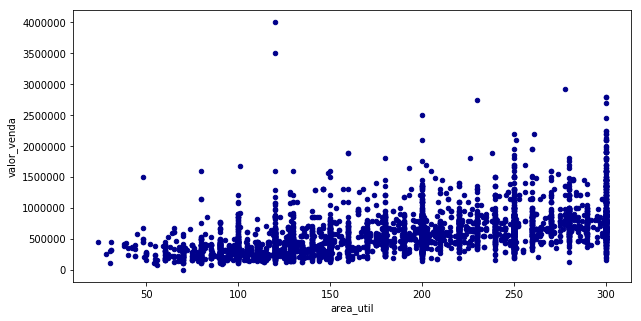

In [38]:
df_zoom = df.loc[df.area_util < 301]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

(4212, 17)


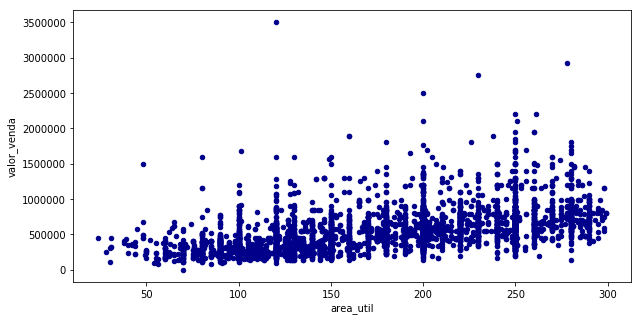

In [39]:
df_zoom = df.loc[(df.area_util < 300) & (df.valor_venda < 4000000)]
print(df_zoom.shape)
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

(409, 17)


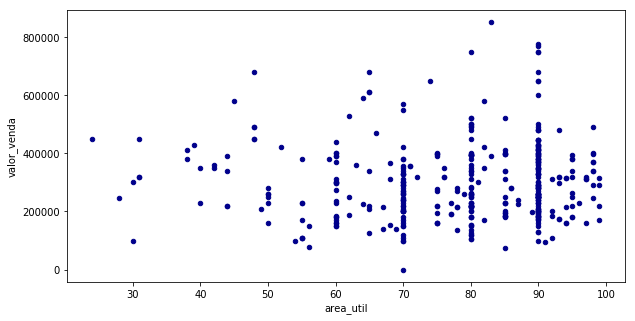

In [40]:
df_zoom = df.loc[(df.area_util < 100) & (df.valor_venda < 1000000)]
print(df_zoom.shape)
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

In [41]:

lat = -15.752353
long = -47.8830672
area = 87
quartos = 3.0

apto_411_n = [[area,quartos,lat,long]]

previsao = reg.predict(apto_411_n)[0]

correcao = previsao * 0.21
print("previsao de preço: ", previsao -  correcao)

previsao de preço:  267109.5333333334


In [42]:

lat = -15.738213539123535
long = -47.897647857666015
area = 89
quartos = 3.0

apto_316_n = [[area,quartos,lat,long]]

previsao = reg.predict(apto_316_n)[0]

correcao = previsao * 0.21
print("previsao de preço: ", previsao -  correcao)

previsao de preço:  288310.5


In [43]:

lat = -15.8567516
long = -48.0688715

area = 70
quartos = 3.0

apto_samambaia = [[area,quartos,lat,long]]

previsao = reg.predict(apto_samambaia)[0]

correcao = previsao * 0.21
print("previsao de preço: ", previsao -  correcao)

previsao de preço:  209128.8


In [44]:

lat = -15.8284829
long = -48.0295519

area = 58
quartos = 2.0

apto_aguas = [[area,quartos,lat,long]]

previsao = reg.predict(apto_aguas)[0]

correcao = previsao * 0.21
correcao = 0
print("previsao de preço: ", previsao -  correcao)

previsao de preço:  284097.75


## Persist model

In [46]:
import pickle
pickle.dump(reg, open('models/random-forest-regressor-casas-01-2020.pickle', 'wb'))

## Load & test

In [47]:
loaded_model = pickle.load(open('models/random-forest-regressor-casas-01-2020.pickle', 'rb'))

lat = -15.8370797
long = -48.0328069

area = 32
quartos = 1.0

apto_aguas = [[area,quartos,lat,long]]

previsao = loaded_model.predict(apto_aguas)[0]

correcao = previsao * 0.21
correcao = 0
print("previsao de preço: ", previsao -  correcao)

previsao de preço:  274597.83
